# Supplementary Figures

**Summary:**

This notebook compiles the scripts that were used to generate the supplementary Figures.

- **Supplementary Figure 2:** Identification of direct-cDNA sequencing adapters

- **Supplementary Figure 3:** Measured length of 5' and 3' soft-clips

- **Supplementary Figure 4.a:** Origin of supplementary alignments

- **Supplementary Figure 4.b:** Size distribution of supplementary alignments

- **Supplementary Figure 5:** Measure of base quality across all sequencing experiments

- **Supplementary Figure 6:** Strand bias in ONT direct-cDNA experiments

- **Supplementary Figure 7:** Method for evaluating base quality

- **Supplementary Figure 8:** high confidence SL matchs are located near the alignment start

---
<br>



## Import libraries

In [1]:
import re
import pandas as pd
import numpy as np
import pysam
import parasail
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from upsetplot import plot
from scipy.stats import gaussian_kde

## Settings for saving figures as pdf

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Opening Dataset file

In [3]:
# Open dataset generated as part of the pre-processing step
dataset = pd.read_csv('dataset_+SL_+hairpin.tsv', sep='\t')

<br>

# Supplementary Figure 2: Identification of direct-cDNA sequencing adapters

In [4]:
DEFAULT_ALIGN_PARAMS = {'match': 1,
                        'mismatch': 0,
                        'gap_open': 2,    # penalty to create a gap
                        'gap_extend': 1}  # penalty to extend a gap (must have created before)


def semi_global_alignment(reference, query, params=DEFAULT_ALIGN_PARAMS):

    subs_mat = parasail.matrix_create("ACGT", params['match'], params['mismatch'])
    alignment = parasail.sg_trace_striped_32(reference, query, params['gap_open'], params['gap_extend'], subs_mat)

    return alignment

In [5]:
def evaluate_alignment(sequence, motif, seqtype, sensitivity=0.7):
    
    ref = len(motif)
    
    # initialize
    aln_score = None
    aln_size = None
    
    # initial alignment (full seq)
    aln = semi_global_alignment(sequence, motif)
    score = aln.score
    
    # shorter alignments
    if score < len(motif) * sensitivity:
        
        for pos in reversed(range(15, len(motif), 1)):
            
            if seqtype == "5SC":
                aln = semi_global_alignment(sequence, motif[-pos:])
            elif seqtype == "3SC":
                aln = semi_global_alignment(sequence, motif[:pos])
            else:
                break
                
            score = aln.score

            if score < sensitivity * pos:
                continue
            else:
                aln_score = score
                aln_size = pos
                break

    else:
        aln_score = score
        aln_size = len(motif)
        
    
    return aln_score, aln_size


<br>

## a) Analysis of Sense reads

Per ONT documentation, the SSP region enter the nanopore first (5' end of the cDNA sense strand) and the poly(A)+VNP adapters exits last (3' end)

In [6]:
NAME = []
SSP_scores = []
SSP_sizes = []
POLYA_scores = []
POLYA_sizes = []

runs = ['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6']

for ID in runs:

    input_file = f'/Volumes/elegans/rna_sequencing/{ID}/{ID}-transcriptome_sorted.bam'

    with pysam.AlignmentFile(input_file,'rb') as alignments:

        for read in alignments:

            if not read.is_unmapped and not read.is_supplementary and read.seq is not None:
                
                if not read.is_reverse:

                    NAME.append(read.query_name)

                    ### 5' soft-clip
                    aln_start = read.query_alignment_start
                    if aln_start >= 27:
                        
                        SC5_sequence = str(read.seq[:aln_start])

                        # SSP search
                        score, size = evaluate_alignment(SC5_sequence, 'TTTCTGTTGGTGCTGATATTGCTGGG', '5SC')
                        SSP_scores.append(score)
                        SSP_sizes.append(size)
                    
                    else:
                        SSP_scores.append(None)
                        SSP_sizes.append(None)

                    ### 3' soft-clip
                    aln_end = read.query_alignment_end
                    
                    if len(read.seq)-aln_end >= 20:
                        
                        SC3_sequence = str(read.seq[aln_end:])
                        
                        # poly(A) search
                        score, size = evaluate_alignment(SC3_sequence, 'AAAAAAAAAAGAAGATAGAGCGACAGGC', '3SC')
                        POLYA_scores.append(score)
                        POLYA_sizes.append(size)
                    
                    else:
                        POLYA_scores.append(None)
                        POLYA_sizes.append(None)
                        
sense_search = pd.DataFrame(dict(read=NAME,SSP_SCORE=SSP_scores, SSP_SIZE=SSP_sizes,
                                 POLYA_SCORE=POLYA_scores, POLYA_SIZE=POLYA_sizes))

sense_search = sense_search.fillna(False)

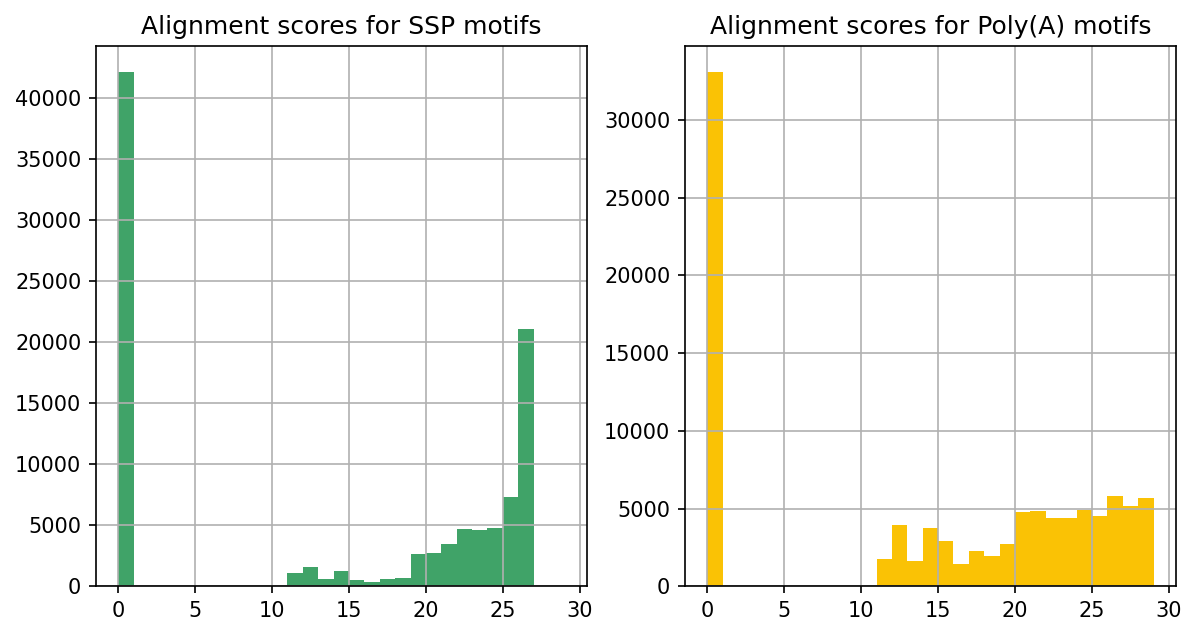

In [7]:
%matplotlib inline

fig, ax = plt.subplots(ncols=2, sharey=False, figsize=(8, 4), dpi=150)

sense_search['SSP_SCORE'].hist(bins=[i for i in range(0,30,1)], ax=ax[0], color='#40a368')
ax[0].set_title('Alignment scores for SSP motifs')

sense_search['POLYA_SCORE'].hist(bins=[i for i in range(0,30,1)], ax=ax[1], color='#fac205')
ax[1].set_title('Alignment scores for Poly(A) motifs')

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2)

In [8]:
sense_search

,read,SSP_SCORE,SSP_SIZE,POLYA_SCORE,POLYA_SIZE
0,694b4446-a948-47ae-9b6d-9b6bbb78f9f9,False,False,False,False
1,8ca713dd-d09d-42f7-8719-d30840915891,False,False,20,28
2,997374a4-a249-4223-8243-4ed891615f7c,23,26,False,False
3,f0386f8c-958b-4f5f-8f0f-e5b204cab9b1,12,17,False,False
4,dd0ca0ff-821f-45a3-89b2-aa66ab6df7e7,False,False,12,17
...,...,...,...,...,...
100005,a0998b36-93a0-45c2-b7c2-486d0a12e57c,False,False,False,False
100006,e41d36ce-42b6-4399-9952-cf5522404412,21,26,False,False
100007,c71cd828-ddb9-415e-94fe-7cf178282563,25,26,False,False
100008,f3a5d991-7573-4f64-9994-30869f3411aa,25,26,20,28


In [9]:
# format search result
sense_search['SSP'] = sense_search['SSP_SCORE'].apply(lambda x: True if x > 15 else False)
sense_search['POLYA'] = sense_search['POLYA_SCORE'].apply(lambda x: True if x > 15 else False)
sense_motifs = sense_search.set_index('read')
sense_motifs = sense_motifs[['SSP','POLYA']]


# get SL data for sense reads in SSP experiments
sense_sl = dataset[(dataset['run'].str.contains('SSP')) & (dataset['read_orientation']=='sense')]
sense_sl = sense_sl[['read','ROBUST_SL']].set_index('read')
sense_sl['SL'] = sense_sl['ROBUST_SL'].map({'NOT FOUND':False, 'FOUND':True})
sense_sl = sense_sl[['SL']]


# add together
sense_summary = pd.concat([sense_motifs, sense_sl], axis=1, join='outer')
sense_summary

,SSP,POLYA,SL
694b4446-a948-47ae-9b6d-9b6bbb78f9f9,False,False,False
8ca713dd-d09d-42f7-8719-d30840915891,False,True,False
997374a4-a249-4223-8243-4ed891615f7c,True,False,False
f0386f8c-958b-4f5f-8f0f-e5b204cab9b1,False,False,False
dd0ca0ff-821f-45a3-89b2-aa66ab6df7e7,False,False,False
...,...,...,...
a0998b36-93a0-45c2-b7c2-486d0a12e57c,False,False,False
e41d36ce-42b6-4399-9952-cf5522404412,True,False,False
c71cd828-ddb9-415e-94fe-7cf178282563,True,False,False
f3a5d991-7573-4f64-9994-30869f3411aa,True,True,False


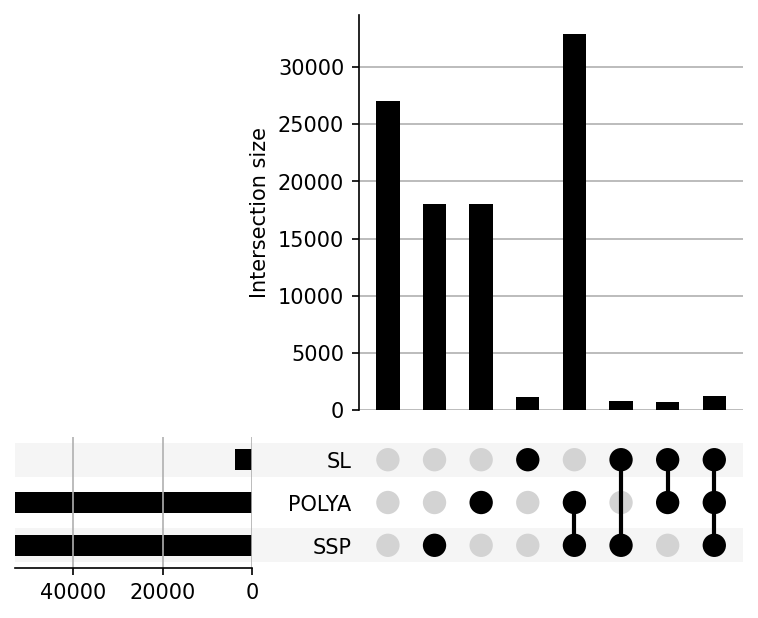

In [10]:
%matplotlib inline

# Count genes per set
sense_cat = sense_summary.groupby(['SSP', 'POLYA', 'SL']).size()

# Show upset plot
upset_plot = plot(sense_cat, fig=plt.figure(figsize=(8,4),dpi=150), sort_categories_by=None, facecolor='k', sort_by='degree', totals_plot_elements=5, intersection_plot_elements=8)

# Save plot
plt.savefig('Sup_Fig_2-upset_adapter_search_(sense).pdf', dpi=800, bbox_inches='tight')

<br>

## b) Analysis of Antisense reads with short 5' soft-clip

In [11]:
NAME = []
SSP_scores = []
SSP_sizes = []
POLYA_scores = []
POLYA_sizes = []

runs = ['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6']

for ID in runs:

    input_file = f'/Volumes/elegans/rna_sequencing/{ID}/{ID}-transcriptome_sorted.bam'

    with pysam.AlignmentFile(input_file,'rb') as alignments:

        for read in alignments:

            if not read.is_unmapped and not read.is_supplementary and read.seq is not None:
                
                if read.is_reverse and read.query_alignment_start <= 80:

                    NAME.append(read.query_name)

                    ### 5' soft-clip
                    aln_start = read.query_alignment_start
                    if aln_start >= 27:
                        
                        SC5_sequence = str(read.seq[:aln_start])

                        # SSP search
                        score, size = evaluate_alignment(SC5_sequence, 'TTTCTGTTGGTGCTGATATTGCTGGG', '5SC')
                        SSP_scores.append(score)
                        SSP_sizes.append(size)
                    
                    else:
                        SSP_scores.append(None)
                        SSP_sizes.append(None)

                    ### 3' soft-clip
                    aln_end = read.query_alignment_end
                    
                    if len(read.seq)-aln_end >= 20:
                        
                        SC3_sequence = str(read.seq[aln_end:])
                        
                        # poly(A) search
                        score, size = evaluate_alignment(SC3_sequence, 'AAAAAAAAAAGAAGATAGAGCGACAGGC', '3SC')
                        POLYA_scores.append(score)
                        POLYA_sizes.append(size)
                    
                    else:
                        POLYA_scores.append(None)
                        POLYA_sizes.append(None)

                        
short_antisense_search = pd.DataFrame(dict(read=NAME, SSP_SCORE=SSP_scores, SSP_SIZE=SSP_sizes,
                                 POLYA_SCORE=POLYA_scores, POLYA_SIZE=POLYA_sizes))

short_antisense_search = short_antisense_search.fillna(False)

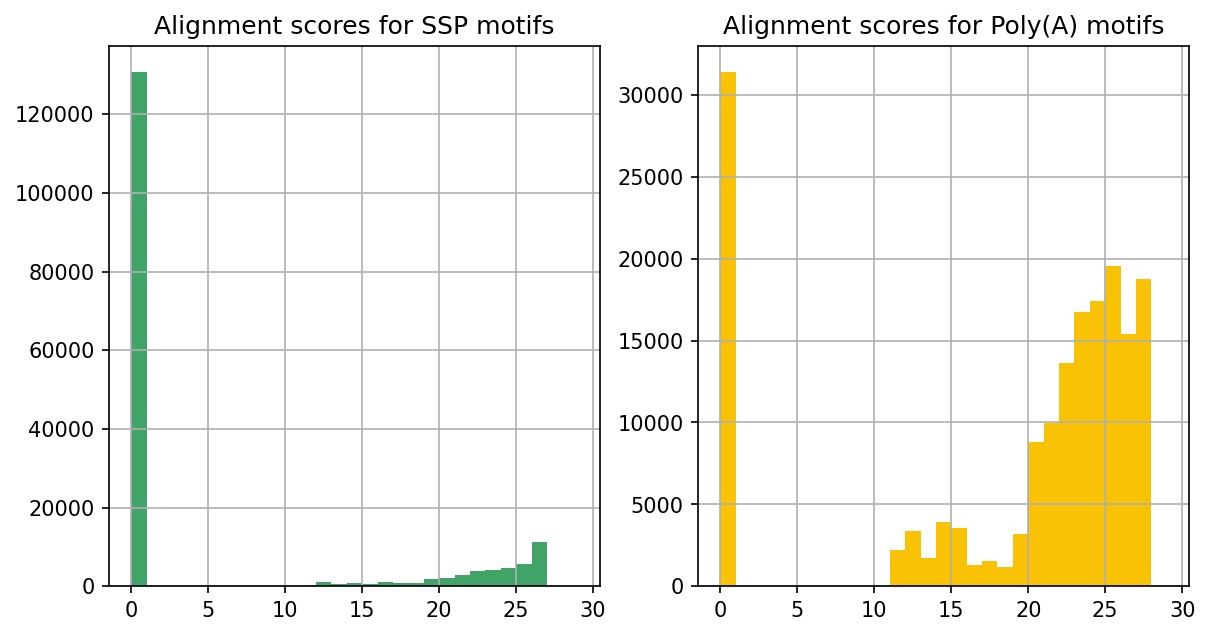

In [12]:
%matplotlib inline

fig, ax = plt.subplots(ncols=2, sharey=False, figsize=(8, 4), dpi=150)

short_antisense_search['SSP_SCORE'].hist(bins=[i for i in range(0,30,1)], ax=ax[0], color='#40a368')
ax[0].set_title('Alignment scores for SSP motifs')

short_antisense_search['POLYA_SCORE'].hist(bins=[i for i in range(0,30,1)], ax=ax[1], color='#fac205')
ax[1].set_title('Alignment scores for Poly(A) motifs')

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2)

In [13]:
# format search result
short_antisense_search['SSP'] = short_antisense_search['SSP_SCORE'].apply(lambda x: True if x is not False else False)
short_antisense_search['POLYA'] = short_antisense_search['POLYA_SCORE'].apply(lambda x: True if x is not False else False)
short_antisense_motifs = short_antisense_search.set_index('read')
short_antisense_motifs = short_antisense_motifs[['SSP','POLYA']]


# get SL data for antisense reads(with short 5' soft-clip) in SSP experiments
short_antisense_sl = dataset[(dataset['run'].str.contains('SSP')) & (dataset['read_orientation']=='antisense') & (dataset['softclip']==0)]
short_antisense_sl = short_antisense_sl[['read','ROBUST_SL']].set_index('read')
short_antisense_sl['SL'] = short_antisense_sl['ROBUST_SL'].map({'NOT FOUND':False, 'FOUND':True})
short_antisense_sl = short_antisense_sl[['SL']]


# add together
short_antisense_summary = pd.concat([short_antisense_motifs, short_antisense_sl], axis=1, join='outer')
short_antisense_summary

,SSP,POLYA,SL
61c12c34-73fb-46ef-b276-d25c8f30958d,False,True,False
efbee216-03ca-4fd4-bb59-98ee3c02be35,False,True,False
8d673a15-20fa-4d39-9d1f-3839e2527ae1,False,True,False
0993a6ce-6b3f-42f6-9f89-806657b6a450,False,True,False
6160121c-dd7e-4f6f-ad1e-8b0b2dc071db,False,True,False
...,...,...,...
52646f7a-038b-4558-944a-443706c4b3d0,True,False,False
1d5f6d1d-4003-4666-955f-2604294b8818,False,True,False
a878af01-bf10-45c6-b989-f0d4adb42a45,False,False,False
69846323-acae-44a9-aeca-19f58d049125,True,True,False


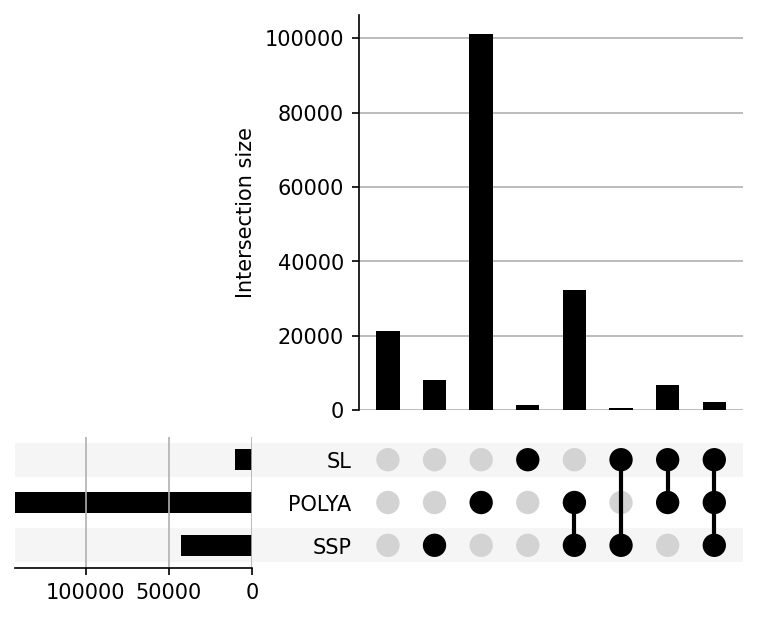

In [14]:
%matplotlib inline

# Count genes per set
short_antisense_cat = short_antisense_summary.groupby(['SSP', 'POLYA', 'SL']).size()

# Show upset plot
upset_plot = plot(short_antisense_cat, fig=plt.figure(figsize=(8,4),dpi=150), sort_categories_by=None, facecolor='k', sort_by='degree', totals_plot_elements=5, intersection_plot_elements=8)

# Save plot
plt.savefig('Sup_Fig_2-upset_adapter_search_(antisense_short_5SC).pdf', dpi=800, bbox_inches='tight')

<br>

## c) Analysis of Antisense reads with long 5' soft-clip

In [15]:
NAME = []
SSP_scores = []
SSP_sizes = []
POLYA_scores = []
POLYA_sizes = []

runs = ['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6']

for ID in runs:

    input_file = f'/Volumes/elegans/rna_sequencing/{ID}/{ID}-transcriptome_sorted.bam'

    with pysam.AlignmentFile(input_file,'rb') as alignments:

        for read in alignments:

            if not read.is_unmapped and not read.is_supplementary and read.seq is not None:
                
                if read.is_reverse and read.query_alignment_start > 80:

                    NAME.append(read.query_name)

                    ### 5' soft-clip
                    aln_start = read.query_alignment_start
                    
                    SC5_sequence = str(read.seq[aln_start-80:aln_start])
                       
                    # SSP search
                    score, size = evaluate_alignment(SC5_sequence, 'TTTCTGTTGGTGCTGATATTGCTGGG', '5SC')
                    SSP_scores.append(score)
                    SSP_sizes.append(size)
 

                    ### 3' soft-clip
                    aln_end = read.query_alignment_end
                    
                    if len(read.seq)-aln_end >= 20:
                        
                        SC3_sequence = str(read.seq[aln_end:])
                        
                        # poly(A) search
                        score, size = evaluate_alignment(SC3_sequence, 'AAAAAAAAAAGAAGATAGAGCGACAGGC', '3SC')
                        POLYA_scores.append(score)
                        POLYA_sizes.append(size)
                    
                    else:
                        POLYA_scores.append(None)
                        POLYA_sizes.append(None)
                    


                        
long_antisense_search = pd.DataFrame(dict(read=NAME, SSP_SCORE=SSP_scores, SSP_SIZE=SSP_sizes,
                                          POLYA_SCORE=POLYA_scores, POLYA_SIZE=POLYA_sizes))

long_antisense_search = long_antisense_search.fillna(False)

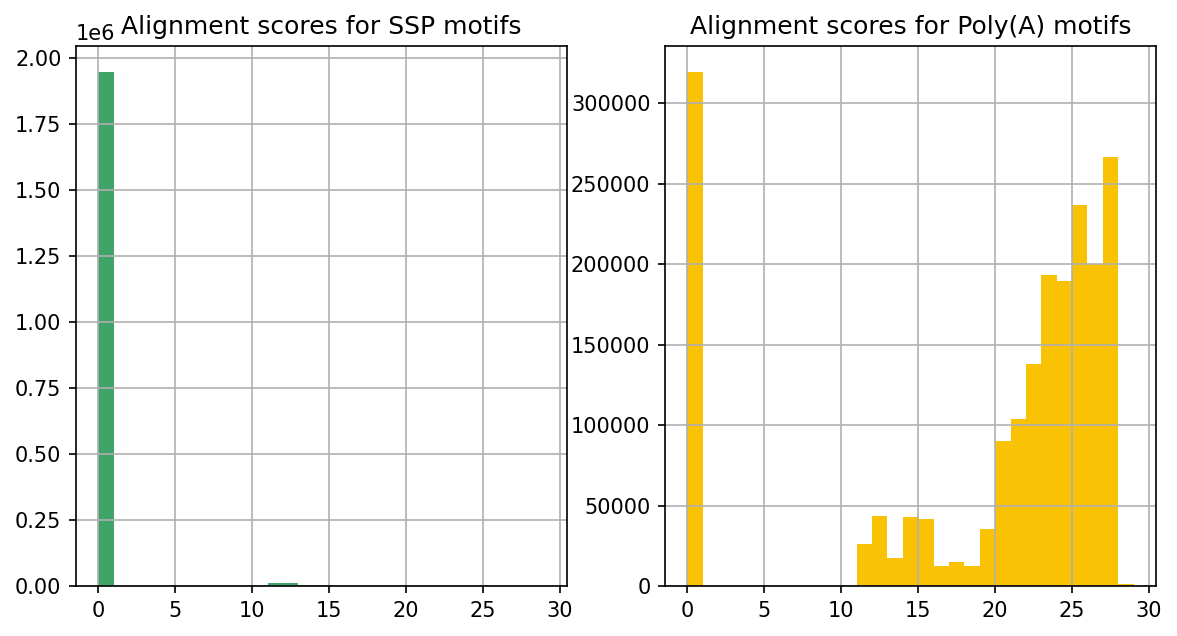

In [16]:
%matplotlib inline

fig, ax = plt.subplots(ncols=2, sharey=False, figsize=(8, 4), dpi=150)

long_antisense_search['SSP_SCORE'].hist(bins=[i for i in range(0,30,1)], ax=ax[0], color='#40a368')
ax[0].set_title('Alignment scores for SSP motifs')

long_antisense_search['POLYA_SCORE'].hist(bins=[i for i in range(0,30,1)], ax=ax[1], color='#fac205')
ax[1].set_title('Alignment scores for Poly(A) motifs')

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2)

In [17]:
# format search result
long_antisense_search['SSP'] = long_antisense_search['SSP_SCORE'].apply(lambda x: True if x is not False else False)
long_antisense_search['POLYA'] = long_antisense_search['POLYA_SCORE'].apply(lambda x: True if x is not False else False)
long_antisense_motifs = long_antisense_search.set_index('read')
long_antisense_motifs = long_antisense_motifs[['SSP','POLYA']]

# get SL data for antisense reads(with short 5' soft-clip) in SSP experiments
long_antisense_sl = dataset[(dataset['run'].str.contains('SSP')) & (dataset['read_orientation']=='antisense') & (dataset['softclip']==1)]
long_antisense_sl = long_antisense_sl[['read','ROBUST_SL']].set_index('read')
long_antisense_sl['SL'] = long_antisense_sl['ROBUST_SL'].map({'NOT FOUND':False, 'FOUND':True})
long_antisense_sl = long_antisense_sl[['SL']]

# add together
long_antisense_summary = pd.concat([long_antisense_motifs, long_antisense_sl], axis=1, join='outer')
long_antisense_summary

,SSP,POLYA,SL
9291b2e1-006e-4416-94d1-47443f44cc58,True,True,False
6280d610-7c3f-426a-9a77-7ee663a1097d,True,True,False
27a122f8-6662-4831-ba32-8f25f83ce737,False,True,False
36419d20-5b58-4f0b-869b-5215f70cc202,False,True,True
2abf03ab-8b41-4212-b53f-0fdfb2d6582c,False,True,False
...,...,...,...
3c189ae6-493e-421f-80cb-389ace39d63e,False,True,False
92e4290c-973b-4e48-9615-9da26279eaf9,False,True,False
45a3ad55-36e9-4a0f-bfb2-7c43ef107e6e,False,True,False
91db2c75-b299-4b54-923b-5746518d7948,False,True,False


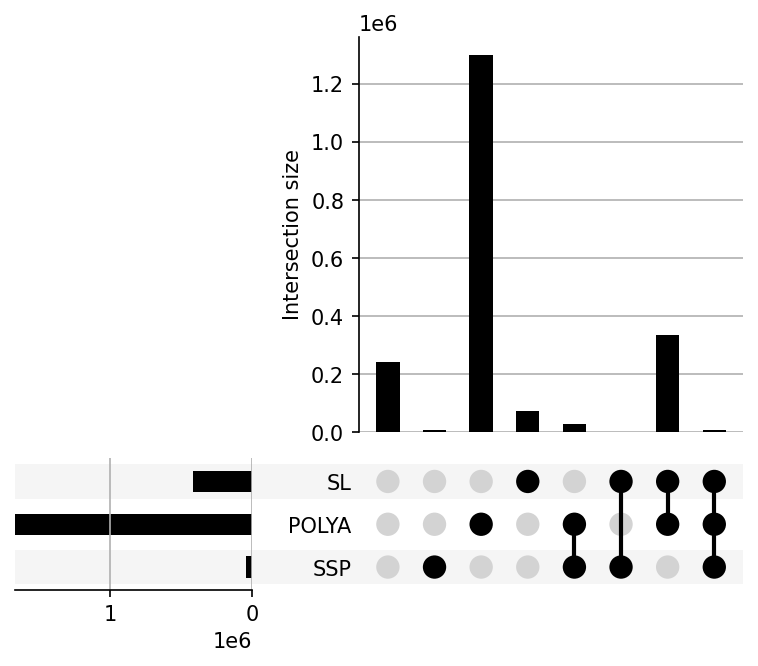

In [18]:
%matplotlib inline

# Count genes per set
long_antisense_cat = long_antisense_summary.groupby(['SSP', 'POLYA', 'SL']).size()

# Show upset plot
upset_plot = plot(long_antisense_cat, fig=plt.figure(figsize=(8,4),dpi=150), sort_categories_by=None, facecolor='k', sort_by='degree', totals_plot_elements=5, intersection_plot_elements=8)

# Save plot
plt.savefig('Sup_Fig_2-upset_adapter_search_(antisense_long_5SC).pdf', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig 2:**<br></font>
For each read evaluated, we performed a sequence search for the SSP and SL motifs on the 5’
soft-clip region, and for the poly(A) motif on the 3’ soft-clip region.

---

<br>

# Supplementary Figure 3: Measured length of 5' and 3' soft-clips

In [19]:
SC3_length = []
SC5_length = []
aln_length = []
names = []

runs = ['SSP_1', 'SSP_2', 'SSP_3']

for ID in runs:

    input_file = f'/Volumes/elegans/rna_sequencing/{ID}/{ID}-transcriptome_sorted.bam'

    with pysam.AlignmentFile(input_file,'rb') as alignments:
    
        for read in alignments:

            if not read.is_unmapped and not read.is_supplementary and read.seq is not None:

                name = read.query_name
                aln = read.query_alignment_length
                start = read.query_alignment_start
                end = read.query_length - read.query_alignment_end

                names.append(name)
                aln_length.append(aln)
                SC5_length.append(start)
                SC3_length.append(end)

stats = pd.DataFrame(dict(read=names, softclip5=SC5_length, softclip3=SC3_length, alignment=aln_length))

In [20]:
median_5SC = int(np.median(stats['softclip5']))
median_3SC = int(np.median(stats['softclip3']))

print(f"5' soft-clip median size: {median_5SC}")
print(f"3' soft-clip median size: {median_3SC}")

5' soft-clip median size: 416
3' soft-clip median size: 60


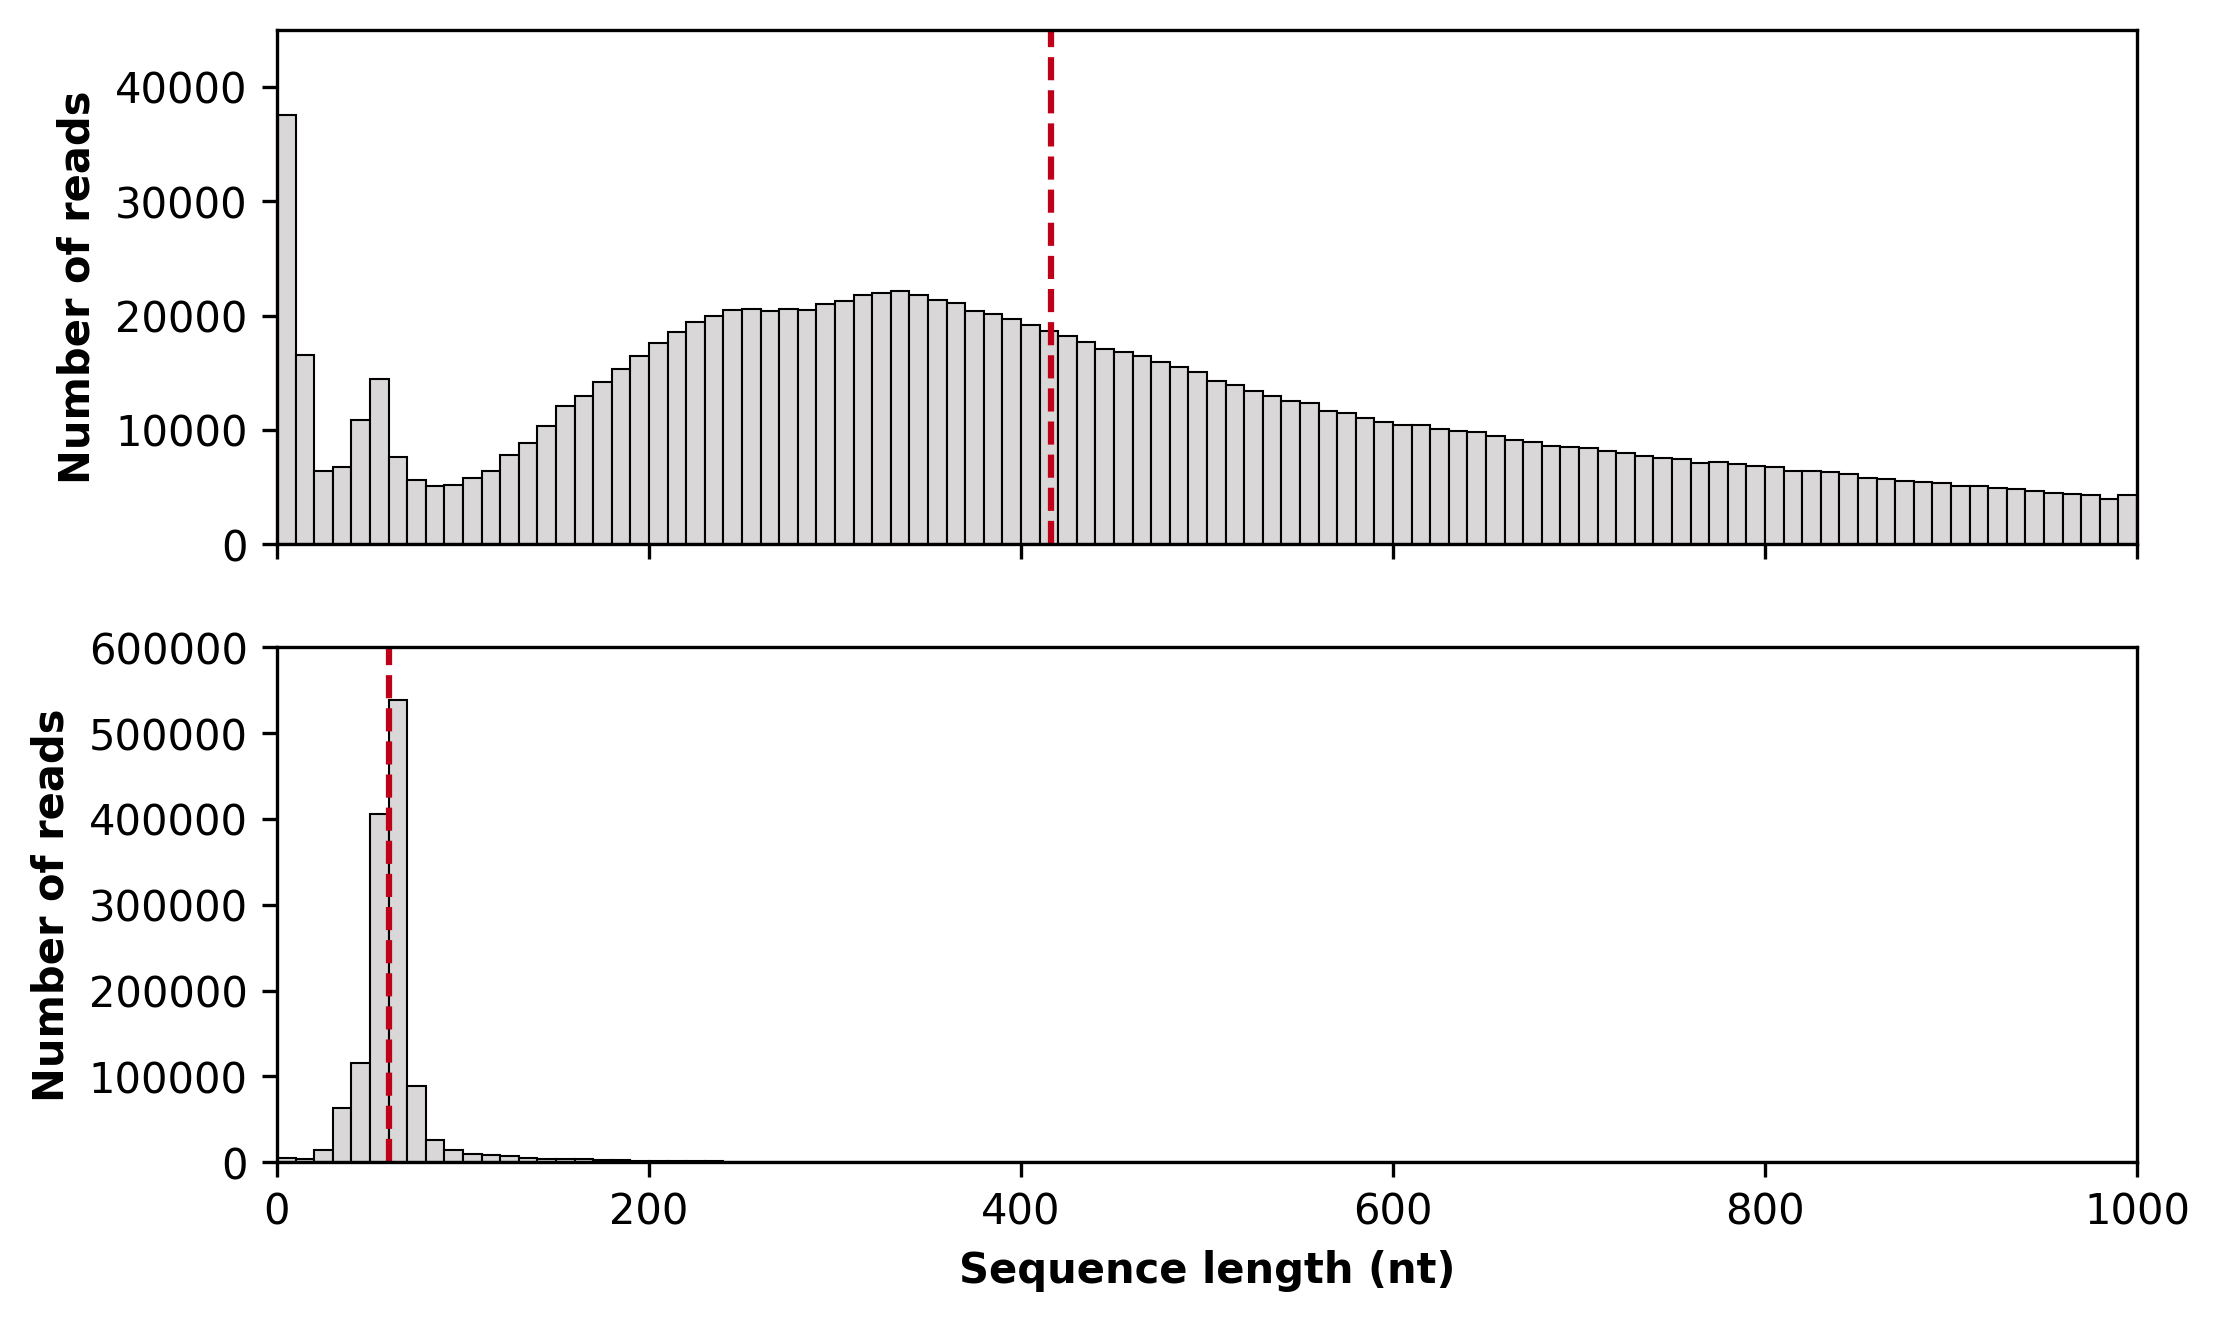

In [21]:
%matplotlib inline

#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8,5), nrows=2, sharex=True, dpi=300)

# 5' soft-clip
stats['softclip5'].hist(bins=[i for i in range(0, 1010, 10)], ax=ax[0], color='#d9d7d7', edgecolor='k', linewidth=0.5)
ax[0].vlines(x=median_5SC, ymin=0, ymax=45000, colors='#be0119', linestyles='dashed', linewidth=1.5)
ax[0].set_ylim(0, 45000)
ax[0].grid(False)

# 3' soft-clip
stats['softclip3'].hist(bins=[i for i in range(0, 1010, 10)], ax=ax[1], color='#d9d7d7', edgecolor='k', linewidth=0.5)
ax[1].vlines(x=median_3SC, ymin=0, ymax=600000, colors='#be0119', linestyles='dashed', linewidth=1.5)
ax[1].set_ylim(0, 600000)
ax[1].grid(False)

# plot settings
plt.xlim(0,1000)
ax[0].set_ylabel('Number of reads', weight='bold')
ax[1].set_ylabel('Number of reads', weight='bold')
ax[1].set_xlabel('Sequence length (nt)', weight='bold')

plt.savefig('Sup_Fig_1.a-stats.pdf', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig 3:**<br></font>
Length of soft-clip region was plotted as an histogram (bins of 10nt) and median length was measured (shown in red). **Top:** 5’ soft-clip sequences (median length = 416nt). **Bottom:** 3’ soft-clip sequences (median length = 60nt). 

---

<br>

# Supplementary Figure 4: Analysis of supplementary alignments

## a) Origin of supplementary alignments

In [22]:
PA_name = []
PA_ref = []
PA_ts = []       
SA_ref = []
SA_ts = []

total_reads = 0
SA_reads = 0


runs = ['SSP_1', 'SSP_2', 'SSP_3']

for ID in runs:

    input_file = f'/Volumes/elegans/rna_sequencing/{ID}/{ID}-transcriptome_sorted.bam'

    with pysam.AlignmentFile(input_file,'rb') as alignments:

        for read in alignments:

            # Take only primary read so we don't get duplicated SA
            if not read.is_unmapped and not read.is_supplementary and read.seq is not None:
                
                # count primary
                total_reads = total_reads + 1
                
                # Take reads who have a SA
                if read.has_tag('SA'):
                    
                    # count primary who has SA
                    SA_reads = SA_reads + 1

                    # Get infos on read
                    name = read.query_name
                    aln_ref = alignments.get_reference_name(read.reference_id)
                    aln_ts = '-' if read.is_reverse else '+'

                    # Get the SA string
                    SA = read.get_tag('SA')

                    # Split the strings into different SA if there more than 1
                    x = SA.split(';')

                    # iterate over each SA
                    for i in range(0, SA.count(';')):

                        ref, map_pos, ts, cigar, mapQ, edist = x[i].split(',')

                        # store values into lists
                        PA_name.append(name)
                        PA_ref.append(aln_ref)
                        PA_ts.append(aln_ts)

                        SA_ref.append(ref)
                        SA_ts.append(ts)

                        
alignments_stats = pd.DataFrame(dict(primary_name=PA_name, primary_ref=PA_ref, primary_ts=PA_ts, supplementary_ref=SA_ref, supplementary_ts=SA_ts))


In [23]:
alignments_stats['same_gene'] = alignments_stats.apply(lambda x: True if re.findall(r"\w+.\d+\B", x['primary_ref']) == re.findall(r"\w+.\d+\B", x['supplementary_ref']) else False, axis=1)
alignments_stats['same_ts'] = alignments_stats.apply(lambda x: True if x['primary_ts'] == x['supplementary_ts'] else False, axis=1)

alignments_stats['same_gene'] = alignments_stats['same_gene'].map({True: 'Same gene', False: 'Different gene' })
alignments_stats['same_ts'] = alignments_stats['same_ts'].map({True:'Same strand' , False: 'Opposite strand' })


In [24]:
percent = round(SA_reads/total_reads*100, 2)

print(f'primary alignments : {total_reads}')
print(f'supplementary alignments : {SA_reads} ({percent}%)')

primary alignments : 1337404
supplementary alignments : 436088 (32.61%)


In [25]:
aln_dict = {'No Supplementary alignments':total_reads-SA_reads, 'Supplementary alignments':SA_reads}
aln_stats = pd.DataFrame.from_dict(aln_dict, orient='index', columns=['Total']).T
aln_stats

,No Supplementary alignments,Supplementary alignments
Total,901316,436088


In [26]:
sup_aln = alignments_stats.groupby(['same_gene', 'same_ts']).size().reset_index().pivot(columns='same_ts', index='same_gene', values=0)
sup_aln = sup_aln.sort_index(ascending=False)
sup_aln = sup_aln[['Same strand', 'Opposite strand']]
sup_aln

same_ts,Same strand,Opposite strand
same_gene,,
Same gene,3715,428034
Different gene,4880,6613


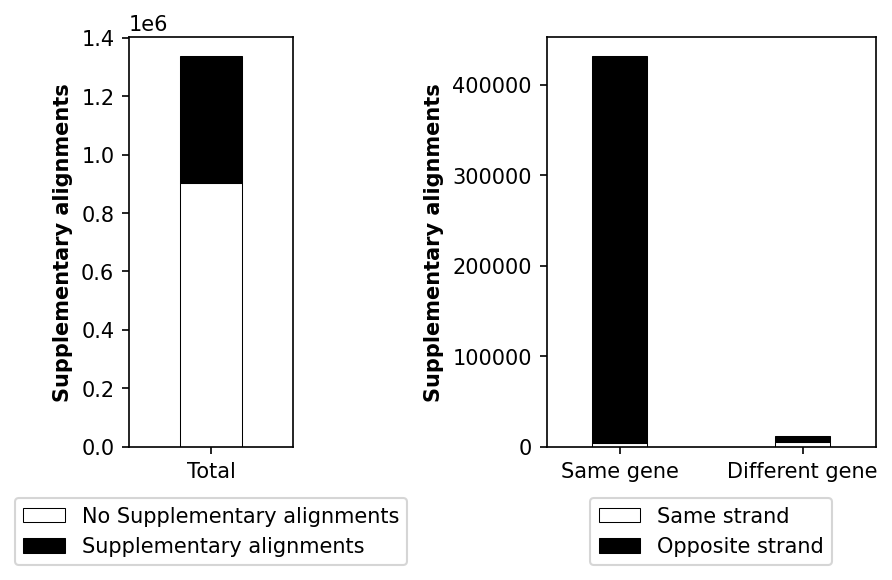

In [27]:
%matplotlib inline

fig, ax = plt.subplots(ncols=2, sharey=False, dpi=150, gridspec_kw={ 'width_ratios': [1, 2]})

aln_stats.plot(kind='bar', stacked=True, ax=ax[0], rot=0, width=0.3, color=['#ffffff', '#000000'], linewidth=0.5, edgecolor='black')
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax[0].set_ylabel('Supplementary alignments', weight='bold')


sup_aln.plot(kind='bar', stacked=True, ax=ax[1],rot=0, width=0.3, color=['#ffffff', '#000000'], linewidth=0.5, edgecolor='black')
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax[1].set_xlabel('')
ax[1].set_ylabel('Supplementary alignments', weight='bold')

# general plot settings
plt.subplots_adjust(left=0.1, bottom=None, right=0.98, top=None, wspace=1, hspace=None)
plt.tight_layout()

# save
plt.savefig('Sup_Fig_4.a-origin_of_supplementary_alignments.pdf', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig 4a:**<br></font>
32.6% of reads with primary alignments possess supplementary
alignments. Among those, 98% are mapping to the same gene than the primary alignment, but in the opposite orientation.

<br>

## b) Size distribution of supplementary alignments

In [28]:
PA_name = []
PA_length = []
SA_name = []
SA_length = []

runs = ['SSP_1', 'SSP_2', 'SSP_3']

for ID in runs:

    input_file = f'/Volumes/elegans/rna_sequencing/{ID}/{ID}-transcriptome_sorted.bam'

    with pysam.AlignmentFile(input_file,'rb') as alignments:

        for read in alignments:
            
            if read.is_supplementary:
                
                SA_length.append(read.query_alignment_length)
                SA_name.append(read.query_name)
            
            if not read.is_supplementary and not read.is_secondary:
                
                PA_length.append(read.query_alignment_length)
                PA_name.append(read.query_name)


primary = pd.DataFrame(dict(read=PA_name, primary_length=PA_length))
primary = primary.set_index('read')

supplementary = pd.DataFrame(dict(read=SA_name, supplementary_length=SA_length))
supplementary = supplementary.drop_duplicates(['read'], keep=False)
supplementary = supplementary.set_index('read')

primary_plus_supplementary = pd.concat([primary, supplementary], axis=1)
primary_plus_supplementary = primary_plus_supplementary.reindex(supplementary.index)
primary_plus_supplementary = primary_plus_supplementary.astype(int)

In [29]:
primary_plus_supplementary['ratio'] = primary_plus_supplementary['supplementary_length']/primary_plus_supplementary['primary_length']*100

In [30]:
primary_plus_supplementary

,primary_length,supplementary_length,ratio
read,,,
6280d610-7c3f-426a-9a77-7ee663a1097d,1077,602,55.896007
694b4446-a948-47ae-9b6d-9b6bbb78f9f9,645,783,121.395349
2abf03ab-8b41-4212-b53f-0fdfb2d6582c,774,574,74.160207
6585d098-1026-4199-a72e-4b87ddb2c735,588,463,78.741497
b9ce965a-fa37-4c89-844c-24a197f5ae04,1137,1013,89.094107
...,...,...,...
c37ec0e0-6d0f-4775-978f-a55fff68241e,438,228,52.054795
1e0e4317-3038-4cb6-969e-22597b21819f,259,136,52.509653
4c9cc5e0-e976-47de-aef5-0f7fea3bd5f8,689,494,71.698113


In [31]:
# take a sub-samble for faster computing (100K datapoints)
p = primary_plus_supplementary.sample(n=100000)

# Calculate point density
val = np.vstack([p['supplementary_length'], p['primary_length']])
p['gaussian'] = gaussian_kde(val)(val)

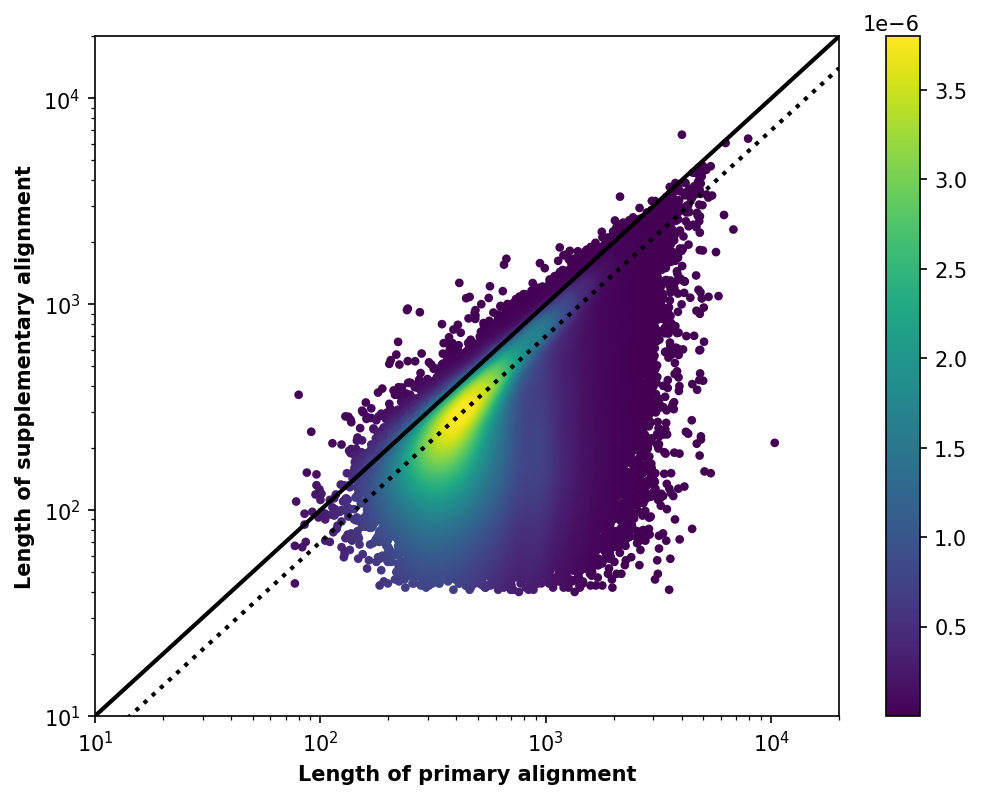

In [32]:
%matplotlib inline

plt.figure(figsize=(8,6), dpi=150)

plt.scatter(x='primary_length', y='supplementary_length', data=p.sort_values('gaussian'), 
            c='gaussian', cmap='viridis', s=10)


plt.plot([1, 20000], [1, 20000],'k', linewidth=2)
plt.plot([1, 20000], [0.70, 14000],'k:', linewidth=2)

plt.ylabel('Length of supplementary alignment', weight='bold')
plt.xlabel('Length of primary alignment', weight='bold')
plt.xscale('log')
plt.yscale('log')

plt.xlim(10,20000)
plt.ylim(10,20000)

# (generate plot here)
cb = plt.colorbar() 

plt.savefig('Sup_Fig_4.b-size_distribution_of_supplementary_alignments.png', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig 4b:**<br></font>
Sizes of primary and supplementary alignments were
compared for reads possessing both. \
Solid black line represent supplementary alignments that are the same size as their
primary alignment (ratio = 1). \
Dotted black line represent supplementary alignments that 70% of the size of their primary
alignment (ratio = 0.7).

---

<br>

# Supplementary Figure 5: Measure of base quality across all sequencing experiments

## 1) Functions for extracting base quality, averaging values and plotting results

In [33]:
# Function for averaging values from a nested list
# Allows to get the mean base quality at any given position

def avgNestedLists(nested_vals):
    
    output = []
    maximum = 0
    for lst in nested_vals:
        if len(lst) > maximum:
            maximum = len(lst)
    
    for index in range(maximum): # Go through each index of longest list
        temp = []
        for lst in nested_vals: # Go through each list
            if index < len(lst): # If not an index error
                temp.append(lst[index])
        output.append(np.nanmean(temp))
    return output

In [34]:
# Function for: 
# 1) extracting base quality value 
# 2) plotting average base quality value per position (relative to alignment start)

def extract_base_quality(alignments):
    
    total = 0
    aligned = []
    unaligned = []
    
    # loop over alignments
    for read in alignments:
        
        # only look primary alignments
        if not read.is_unmapped and not read.is_secondary and not read.is_supplementary and read.seq is not None:
            
            quali = read.query_qualities
            
            # filter for antisense reads
            if quali is not None and read.is_reverse:

                start = read.query_alignment_start
                end = read.query_alignment_end

                # filter for long soft-clips
                if start > 80:

                    # aligned region
                    aligned_qual = list(quali[start:end])
                    aligned.append(aligned_qual)

                    # unaligned (= softclip) region
                    sc_qual = list(quali[:start])
                    sc_qual.reverse()
                    unaligned.append(sc_qual)
                    
                    # count reads
                    total = total+1
                    

    # averaged values
    avgAligned = avgNestedLists(aligned)
    
    avgUnaligned = avgNestedLists(unaligned)
    avgUnaligned.reverse()

    # base quality on Y axis
    avg = avgUnaligned + avgAligned

    # X axis values (= base position relative to alignment start)
    xUnaligned = [i for i in range(-len(avgUnaligned), 1)]
    xAligned = [i for i in range(0, len(avgAligned))]
    
    # Y axis values (= average value)
    yUnaligned = avg[:len(avgUnaligned)+1]
    yAligned = avg[len(avgUnaligned):]
    
    return total, xUnaligned, xAligned, yUnaligned, yAligned


In [35]:

def plotting_base_quality(xUnaligned, yUnaligned, xAligned, yAligned, total, ID, output):

    %matplotlib widget

    sns.set_style('whitegrid', {'axes.edgecolor': '.15', 'axes.linewidth': '1.5', "xtick.major.size": 8, "ytick.major.size": 8, "xtick.minor.size": 5, "ytick.minor.size": 5})

    fig, ax = plt.subplots(figsize=(9.5,3), nrows=1, ncols=3, sharey=True)

    # unaligned region
    ax[0].plot(xUnaligned, yUnaligned, color='#658cbb', alpha=1, label='Unaligned region',linewidth=2)
    ax[0].set_xlim(-1000,-50)
    ax[0].tick_params(axis='y', which='both', left=True)
    ax[0].yaxis.set_minor_locator(MultipleLocator(1))
    ax[0].tick_params(axis='x', which='major', bottom=True)
    ax[0].set_ylabel('Base quality score (PHRED)', weight='bold', size=12)

    # transition region
    ax[1].plot(xUnaligned[-51:], yUnaligned[-51:], color='#658cbb', alpha=1, label='Unaligned region',linewidth=2)
    ax[1].plot(xAligned[:51], yAligned[:51], color='#856798', alpha=1, label='Aligned region', linewidth=2)
    ax[1].vlines(0, 0, 60, 'black', alpha=1, linewidth=1.5, linestyle='dotted')
    ax[1].set_xlim(-50, 50)
    ax[1].tick_params(axis='x', which='major', bottom=True)
    ax[1].set_xlabel('Base position relative to alignment start', weight='bold', size=12)

    # aligned region
    ax[2].plot(xAligned[51:], yAligned[51:], color='#856798', alpha=1, label='Aligned region',linewidth=2)
    ax[2].set_xlim(50, 1000)
    ax[2].tick_params(axis='x', which='major', bottom=True)

    # plot settings
    plt.ylim(0, 45)
    plt.subplots_adjust(left=0.1, bottom=None, right=0.98, top=None, wspace=0.01, hspace=None)
    plt.suptitle(f'{ID} (n = {total} reads)', y=0.95)
    fig.tight_layout()
    
    # save plot
    plt.savefig(output, dpi=800, bbox_inches='tight')
    
    plt.close()

## 2) Generating plots

The following code will generate base quality plots for each experiment ID present in **runs** \
Plots are not directly shown below as it is very computationally heavy.

**SSP experiments:** ['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6'] \
**SL1 experiment:** ['SL1_1'] \
**NP experiments:** ['NP_1', 'NP_2', 'NP_3', 'NP_4', 'NP_5']

In [ ]:
runs = ['SSP_1','SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6', 'SL1_1','NP_1', 'NP_2', 'NP_3', 'NP_4', 'NP_5']

for ID in runs:
    
    # open corresponding file
    file = f'/Volumes/elegans/rna_sequencing/{ID}/{ID}-transcriptome_sorted.bam'
    alignment = pysam.AlignmentFile(file,'rb')
    
    # measure base quality across all reads
    total, xUnaligned, xAligned, yUnaligned, yAligned = extract_base_quality(alignment)
    
    # generate and save plots
    output = f'Fig1B-Base_quality_({ID}).pdf'
    plotting_base_quality(xUnaligned, yUnaligned, xAligned, yAligned, total, ID, output)

<font size="4">**Sup. Fig. 5:**<br></font>
We measured the average base quality value over all the Nanopore reads obtained in each sequencing experiment. 5’ soft-clip region is represented in
blue and aligned region (primary alignment) is represented in purple.

---

<br>

# Supplementary Figure 6: Strand bias in ONT direct-cDNA experiments

-> See code from **Figure 1a & 1d** in **Figure1_notebook**.

---

<br>

# Supplementary Figure 7: Method for evaluating base quality

In [37]:
# Function for averaging values from a nested list

def avgNestedLists(nested_vals):
    """
    Averages a 2-D array and returns a 1-D array of all of the columns
    averaged together, regardless of their dimensions.
    """
    output = []
    maximum = 0
    for lst in nested_vals:
        if len(lst) > maximum:
            maximum = len(lst)
    
    for index in range(maximum): # Go through each index of longest list
        temp = []
        for lst in nested_vals: # Go through each list
            if index < len(lst): # If not an index error
                temp.append(lst[index])
        output.append(np.nanmean(temp))
    return output

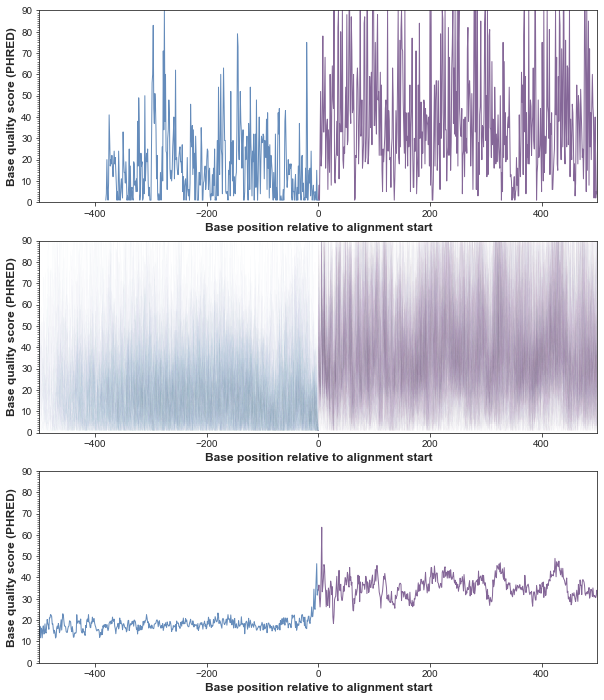

In [38]:
# open alignment file to process
aln_file = '/Volumes/elegans/rna_sequencing/SSP_1/SSP_1-transcriptome_sorted.bam'
alignment = pysam.AlignmentFile(aln_file,'rb')


# select randomly 10K reads

# conditions:
# - antisense reads
# - long 5' soft clip

_selected = dataset[(dataset['run']=='SSP_1') & (dataset['read_orientation']=='antisense') &  (dataset['softclip']==1) & (dataset['gene']=='F40F8.10')]
selected_reads = list(_selected.sample(n=500)['read'])


# plot

%matplotlib inline

sns.set_style('ticks', {'axes.edgecolor': '.15', 'axes.linewidth': '1.5', "xtick.major.size": 8, "ytick.major.size": 8, "xtick.minor.size": 5, "ytick.minor.size": 5})
fig, ax = plt.subplots(figsize=(10,12), ncols=1, nrows=3)


# start looping over alignment
# plot 1 read in top panel
# plot 10K superposed reads in middle panel
# plot averaged mean in bottom panel

ALIGNED = []
UNALIGNED = []
total = 0
max_iter = len(selected_reads)

for read in alignment:

    # only look primary alignments
    if not read.is_unmapped and not read.is_secondary and not read.is_supplementary and read.seq is not None:
        
        if not read.query_name in selected_reads:
            continue
        
        else:
            
            quali = read.query_qualities
            start = read.query_alignment_start
            end = read.query_alignment_end
            
            # counter to check total number of reads processed
            total = total+1
            
            # aligned region
            aligned = list(quali[start:end])
            xAligned = [i for i in range(0, len(aligned))]
            
            # unaligned (= softclip) region
            unaligned = list(quali[:start+1])
            xUnaligned = [i for i in range(-len(unaligned)+1, 1)]

            # append qualities lo list for computting mean values
            ALIGNED.append(aligned)
            _unaligned = unaligned # need to be copied to another variable 
            _unaligned.reverse()   # then modified so it doesn't impact plotting on middle panel
            UNALIGNED.append(_unaligned)

            if total == 25:
                
                ax[0].plot(xAligned, aligned, color='#856798', alpha=1, label='Aligned region',linewidth=1)
                ax[0].plot(xUnaligned, unaligned, color='#658cbb', alpha=1, label='Unaligned region',linewidth=1)
            
            elif total <= 100:


                ax[1].plot(xAligned, aligned, color='#856798', alpha=0.2, label='Aligned region', linewidth=0.05)
                ax[1].plot(xUnaligned, unaligned, color='#658cbb', alpha=0.2, label='Unaligned region', linewidth=0.05)
            
            elif total > 100:
                break
            
            elif total > max_iter:
                print('Finished looping over reads - now computing mean base quality')
                break

### compute mean values for bottom panel and plot

# averaged values
avgAligned = avgNestedLists(ALIGNED)

avgUnaligned = avgNestedLists(UNALIGNED)
avgUnaligned.reverse()

# base quality on Y axis
avg = avgUnaligned + avgAligned

# X axis values (= base position relative to alignment start)
xMeanUnaligned = [i for i in range(-len(avgUnaligned), 1)]
xMeanAligned = [i for i in range(0, len(avgAligned))]

# Y axis values (= average value)
yMeanUnaligned = avg[:len(avgUnaligned)+1]
yMeanAligned = avg[len(avgUnaligned):]

# plotting
ax[2].plot(xMeanUnaligned, yMeanUnaligned, color='#658cbb', alpha=1, label='Unaligned region', linewidth=1)
ax[2].plot(xMeanAligned, yMeanAligned, color='#856798', alpha=1, label='Aligned region', linewidth=1)

#### axis settings

for i in [0,1,2]:
    
    ax[i].set_ylim(0, 90)
    ax[i].set_xlim(-500,500)
    ax[i].set_xlabel('Base position relative to alignment start', weight='bold', size=12)
    ax[i].set_ylabel('Base quality score (PHRED)', weight='bold', size=12)
    ax[i].tick_params(axis='x', which='major', bottom=True)
    ax[i].tick_params(axis='y', which='both', left=True)
    ax[i].yaxis.set_minor_locator(MultipleLocator(1))

plt.savefig('Sup_Fig_7-base_quality_method.pdf', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig. 7:**<br></font>
Method for evaluating base quality. Single read’s base quality contains too much variability
for accurate measurement (**top panel**). Trends in base quality can be observed when looking at larger
samples of reads (**middle panel** - 100 reads shown together). Averaging the base quality per position
across a large sample of reads (**bottom panel**) allows to accurately visualize differences in base quality
between different regions of the reads. Unaligned 5’ soft-clip region is shown in blue and alignment region
in purple.

---

<br>

# Supplementary Figure 8: high confidence SL matchs are located near the alignment start

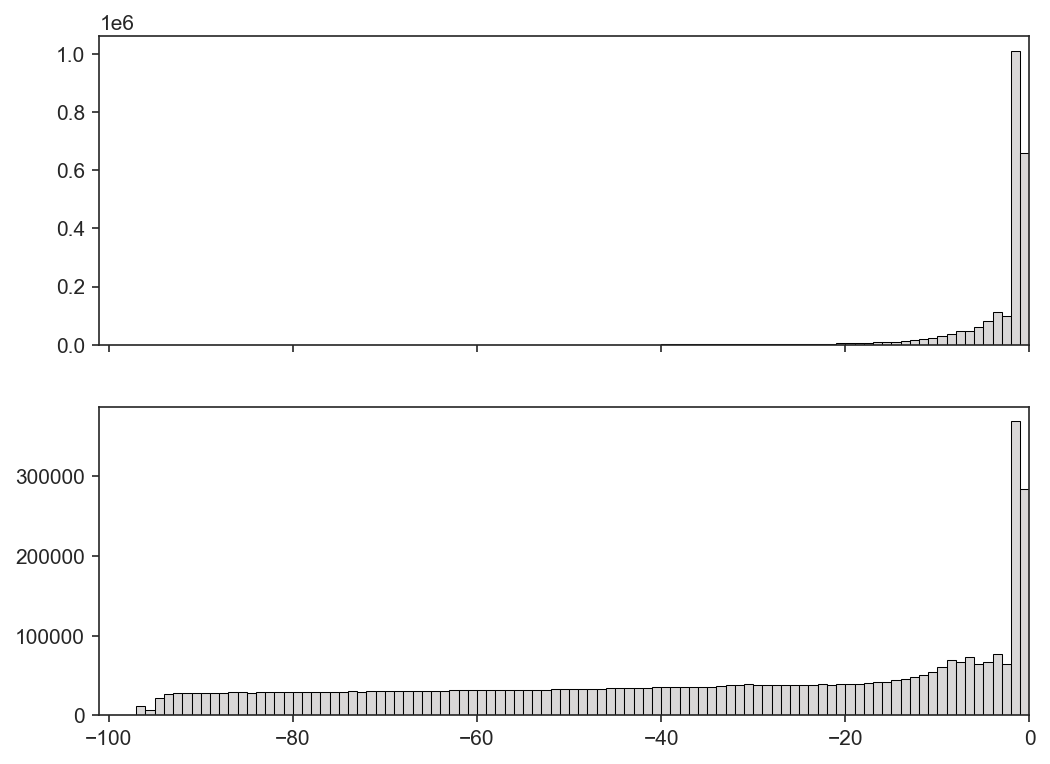

In [39]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True, dpi=150)

# high confidence SL match (score > 15)
high = dataset[dataset['score'] > 15]['distance_to_start'].apply(lambda x: -x if x>=0 else 0)
ax[0].hist(high, bins=[i for i in range(-100,1,1)], color='#d9d7d7',edgecolor = "k", linewidth=0.5)

# low confidence SL match (score < 0)
low = dataset[dataset['score'] < 10]['distance_to_start'].apply(lambda x: -x if x>=0 else 0)
ax[1].hist(low, bins=[i for i in range(-100,1,1)], color='#d9d7d7',edgecolor = "k", linewidth=0.5)

# plots settings
plt.xlim(-101,0)

# save
plt.savefig('Sup_Fig_8-SL_match_(dist_to_start).pdf', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig. 8:**<br></font>
High confidence SL matches are preferentially located near the alignment start. For each SL
sequence identified, we measured their distance to the alignment start. As expected, matches which scored high
(top panel) are found in the direct vicinity of the alignment start. Low-scoring matches (bottom panel) are generally
found all across the 5’ soft-clip region, but a sub-set of those are found where expected making those more
reliable.

<br>